In [1]:
%load_ext autoreload
%autoreload 2
import math
import os
from functools import partial, cached_property
import uproot
import numpy as np
import pandas as pd
import awkward as ak
from tqdm import tqdm
import hist

import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import sys
sys.path.append("../../..")
from hists.parameters import thresholdW0 as defaultThresholdW0
from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.store import HistogramId

from event_visualizer_plotly.utils import EventLoader, EventID, LoadedEvent
from event_visualizer_plotly.locateEvents.utils import makeRatiosPerBeamEnergy
from event_visualizer_plotly.locateEvents.displacedLayerCluster.dataframe_making import findDisplacedLC, fillHistogram
from event_visualizer_plotly.locateEvents.displacedLayerCluster.lookup import lookupLargeDistanceToImpactNotInBarycenter, lookupFractionEnergyOnLayer
from event_visualizer_plotly.locateEvents.displacedLayerCluster.event_display import EventDisplay

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v37'
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
datatypes = ["data", "sim_proton_v46_patchMIP"]

In [3]:
class Finder:
    def __init__(self, datatype:str) -> None:
        inputFileName = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root")
        self.tree:uproot.TTree = uproot.open(inputFileName+":clusters")
        self.eventLoader = EventLoader(inputFileName)
        self.datatype = datatype
    
    def findDisplacedLC(self, lookupFunctions:list=[lookupFractionEnergyOnLayer], maxCount=math.inf):
        self.result = findDisplacedLC(self.tree, lookupFunctions, maxCount=maxCount)
        self.firstDf = self.result[next(iter(self.result))]
        return self
    
    @cached_property
    def display(self, query:str=""):
        return EventDisplay(self.firstDf.query("clus2D_layer<20"), self.eventLoader)

def eventsPerBeamEnergy(datatype:str) -> hist.Hist:
    return histStore.get(HistogramId("EventsPerBeamEnergy", clueParams, datatype)).getHistogram(HistogramKind.COUNT)

In [4]:
data_finder = Finder("data").findDisplacedLC()

100%|██████████| 281873/281873 [06:41<00:00, 702.86it/s] 


In [5]:
sim_finder = Finder("sim_proton_v46_patchMIP").findDisplacedLC()

100%|██████████| 398059/398059 [08:43<00:00, 760.59it/s] 


In [10]:
data_displaced_df = data_finder.firstDf
sim_displaced_df = sim_finder.firstDf
%store data_displaced_df sim_displaced_df

Stored 'data_displaced_df' (DataFrame)
Stored 'sim_displaced_df' (DataFrame)


In [6]:
data_finder.firstDf

,beamEnergy_x,clus2D_x,clus2D_y,clus2D_layer,clus2D_energy,clus2D_size,clus2D_x_barycenter,clus2D_y_barycenter,clus2D_distance_positionToBarycenter,rechits_energy_sum_perLayer,...,clus2D_distance_positionToImpact,clus2D_distance_barycenterToImpact,clus3D_id,clus3D_size,clus2D_id,beamEnergy_y,clus3D_energy,ntupleNumber,event,beamEnergy
eventInternal,,,,,,,,,,,,,,,,,,,,,
64,300.0,0.094261,-0.355702,21,1.570499,25,1.969218,-1.896633,2.426919,1.735797,...,2.452084,0.195591,1.0,3.0,61,300.0,1.698679,435,1509,300.0
111,300.0,-0.895730,0.283688,23,1.328202,24,1.083024,-0.494881,2.126415,1.536511,...,2.783277,0.739225,1.0,4.0,58,300.0,1.502911,435,1632,300.0
134,300.0,4.955517,0.028265,25,1.098429,18,2.895848,-0.594686,2.151814,1.368850,...,2.540150,0.684181,2.0,10.0,58,300.0,1.883834,435,1723,300.0
153,300.0,0.132431,-1.415538,22,1.055957,22,2.130843,-1.162909,2.014317,1.159368,...,2.423884,0.438953,1.0,9.0,46,300.0,1.631735,435,1785,300.0
242,300.0,4.030371,-2.627239,22,2.219056,32,1.866623,-2.309141,2.187005,2.509578,...,2.422474,0.460110,1.0,19.0,56,300.0,5.373298,435,2687,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293,200.0,-0.841691,-0.939486,21,2.870970,37,1.199725,-0.597335,2.069890,3.047148,...,2.736590,0.842348,2.0,4.0,44,200.0,3.199060,676,9953,200.0
5391,200.0,4.966697,-3.168812,20,1.584512,26,3.165514,-1.870378,2.220403,1.624319,...,2.846064,0.636574,1.0,4.0,49,200.0,1.709032,676,8954,200.0
5455,200.0,1.076980,-4.172964,27,1.126744,25,2.173740,-2.127468,2.320977,1.430805,...,3.237755,0.924953,1.0,7.0,61,200.0,1.443388,676,7752,200.0


In [7]:
sim_finder.firstDf.query("event==12833")

,beamEnergy_x,clus2D_x,clus2D_y,clus2D_layer,clus2D_energy,clus2D_size,clus2D_x_barycenter,clus2D_y_barycenter,clus2D_distance_positionToBarycenter,rechits_energy_sum_perLayer,...,clus2D_distance_positionToImpact,clus2D_distance_barycenterToImpact,clus3D_id,clus3D_size,clus2D_id,beamEnergy_y,clus3D_energy,ntupleNumber,event,beamEnergy
eventInternal,,,,,,,,,,,,,,,,,,,,,
3174,80.0,-3.887055,0.0,19,1.444439,23,-1.893593,0.554493,2.069142,1.492706,...,2.894721,0.928633,2.0,2.0,47,80.0,1.482039,3,12833,80.0


In [16]:
sim_finder.display.sampleRandom()

In [44]:
def plot(ratios_dict:dict[str, tuple[list, np.ndarray]], ax=None, alternative_hypothesis="two-sided", lumi_text="", lumi_size=None):
    """ 
    Parameters : 
     - ratios_dict : datatype -> tuple ratio_val, ratio_errors
     - alternative_hypothesis : two-sided or greater 
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    errorbar_kwargs = dict()
    if alternative_hypothesis == "greater":
        errorbar_kwargs["lolims"] = True

    offset_x = 3
    cur_offset = 0
    for datatype, (ratio_val, ratio_errors) in ratios_dict.items():
        ax.errorbar(x=np.array(beamEnergies)+cur_offset, y=ratio_val, yerr=ratio_errors, fmt="o-", #ecolor="black", 
                     label=datatypeToLegendMap[datatype], **errorbar_kwargs)
        cur_offset += offset_x

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Fraction of displaced LC events")
    hep.cms.text("Preliminary", ax=ax)
    #hep.cms.lumitext(f"minLayerSpan={settings['minLayerSpan']}, minFracBeamEnergy={settings['minFractionOfBeamEnergy']:.0%}"
    #                 f"\nmaxLayerOverlap={settings['maxLayerOverlap']}   $e^+$ TB", ax=ax,
    #    fontsize=15)
    hep.cms.lumitext(lumi_text + " $e^+$ TB", fontsize=lumi_size)
    ax.legend()
    #return ratio_val, ratio_errors

maxShowerLayer = {20:7, 30:7, 50:8, 80:9, 100:9, 120:9, 150:10, 200:10, 250:10, 300:10}
def splitAtLayer(h:hist.Hist, layerToSplitAt:dict[int, int], before=True):
    def makeLayerSlice(beamEnergy):
        if before:
            return slice(0, hist.loc(layerToSplitAt[beamEnergy])+1, sum)
        else:
            return slice(hist.loc(layerToSplitAt[beamEnergy]), len, sum)
    return np.array([h[{"beamEnergy":hist.loc(beamEnergy), "layer":makeLayerSlice(beamEnergy)}] for beamEnergy in beamEnergies], dtype="int")

def plotResults(finders:list[Finder], layerSelections=None, **plot_kwargs):
    ratios_dict = {}
    for finder in finders:
        h = fillHistogram(finder.firstDf)
        if layerSelections is not None:
            h = layerSelections(h)
        else:
            h = h.project("beamEnergy")
        ratios_dict[finder.datatype] = makeRatiosPerBeamEnergy(h, eventsPerBeamEnergy(finder.datatype))
    plot(ratios_dict, **plot_kwargs)


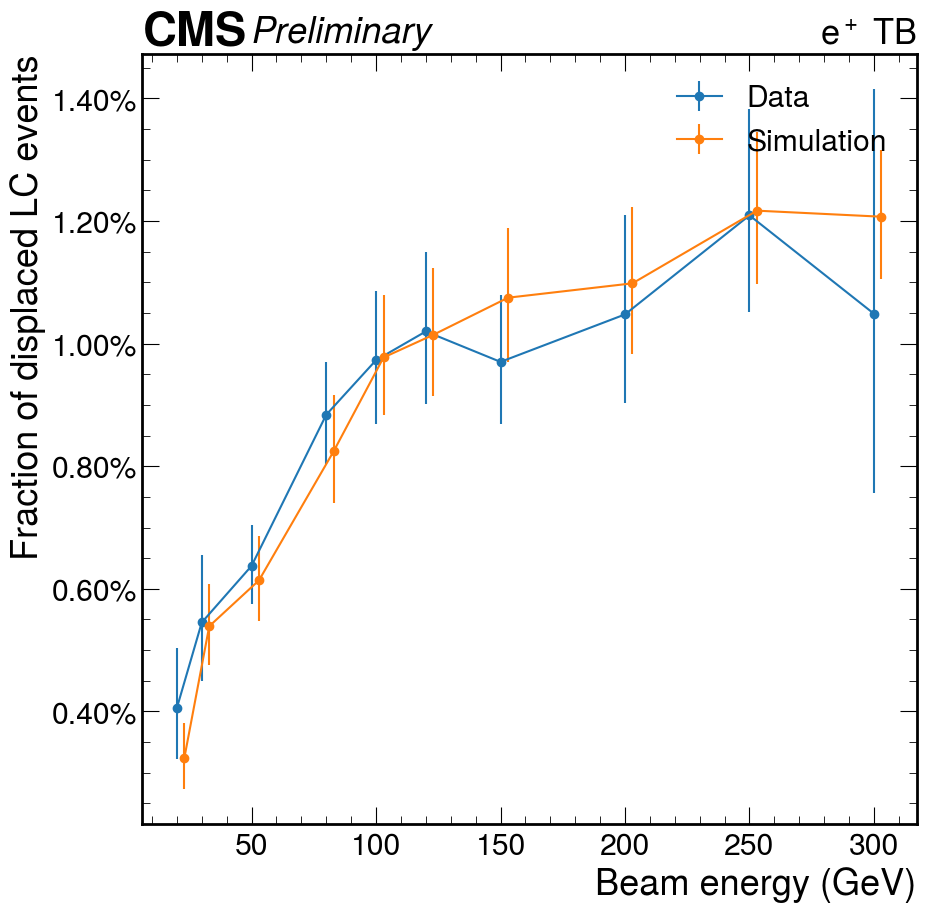

In [47]:
plotResults([data_finder, sim_finder])

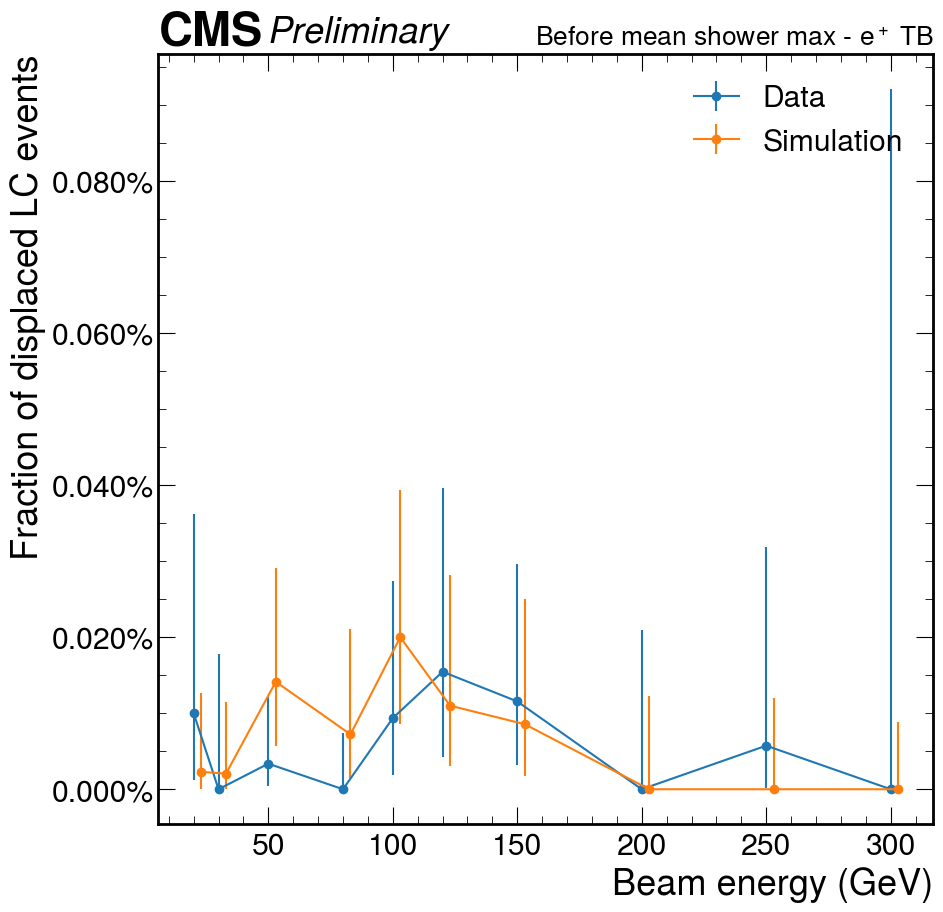

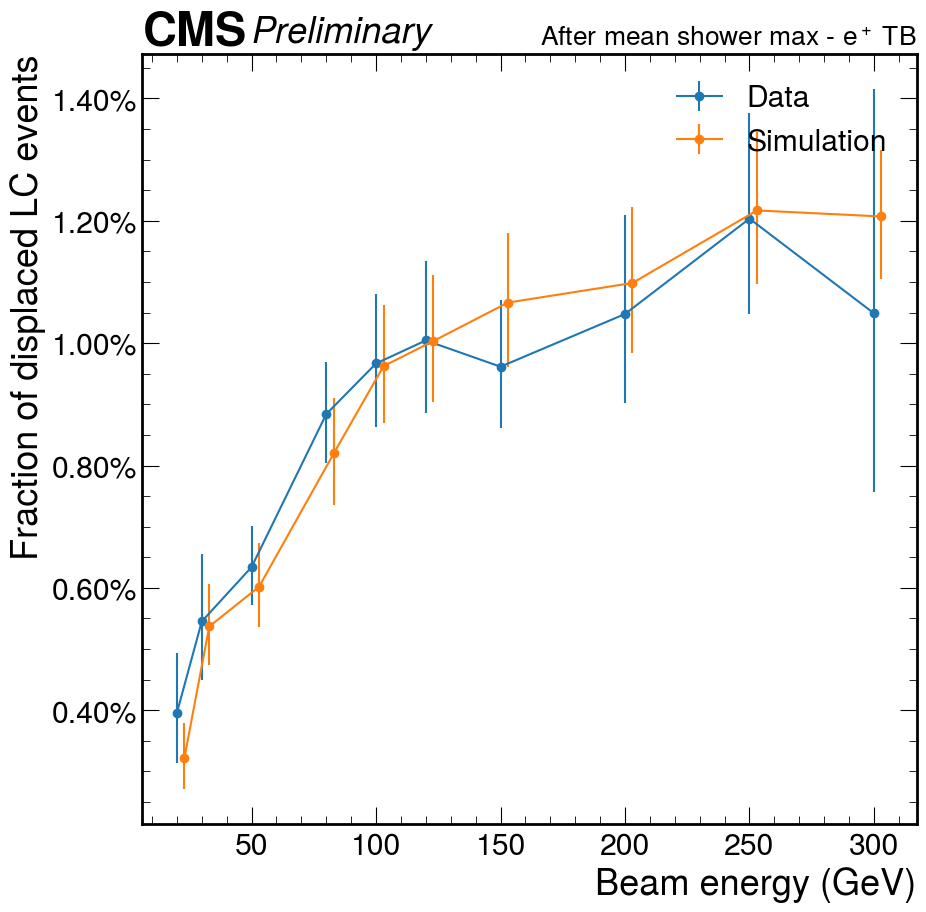

In [46]:
plotResults([data_finder, sim_finder], partial(splitAtLayer, layerToSplitAt=maxShowerLayer, before=True), lumi_text="Before mean shower max -", lumi_size=20)
plotResults([data_finder, sim_finder], partial(splitAtLayer, layerToSplitAt=maxShowerLayer, before=False), lumi_text="After mean shower max -", lumi_size=20)

In [ ]:
printCsvRowsFromDf(full_result_df, source="Clus2DLargeDistancePositionToBarycenter", layerColumn="clus2D_layer")

300;435;2243;23;Clus2DLargeDistancePositionToBarycenter
300;435;4627;28;Clus2DLargeDistancePositionToBarycenter
300;435;8652;27;Clus2DLargeDistancePositionToBarycenter
300;435;479;23;Clus2DLargeDistancePositionToBarycenter
20;442;1630;17;Clus2DLargeDistancePositionToBarycenter
20;451;9981;17;Clus2DLargeDistancePositionToBarycenter
20;451;5763;14;Clus2DLargeDistancePositionToBarycenter
50;456;7197;15;Clus2DLargeDistancePositionToBarycenter
50;456;9540;16;Clus2DLargeDistancePositionToBarycenter
50;456;332;19;Clus2DLargeDistancePositionToBarycenter
50;456;1341;15;Clus2DLargeDistancePositionToBarycenter
50;457;425;18;Clus2DLargeDistancePositionToBarycenter
50;458;2072;17;Clus2DLargeDistancePositionToBarycenter
50;460;5106;28;Clus2DLargeDistancePositionToBarycenter
50;460;1894;20;Clus2DLargeDistancePositionToBarycenter
50;460;2534;17;Clus2DLargeDistancePositionToBarycenter
50;461;7046;17;Clus2DLargeDistancePositionToBarycenter
50;463;2808;17;Clus2DLargeDistancePositionToBarycenter
80;466;63